In [1]:
import pandas as pd
import numpy as np
import spacy
import networkx as nx
import matplotlib.pyplot as plt
from transformers import AutoModelForTokenClassification, AutoTokenizer, pipeline, AutoModelForSequenceClassification
import torch

In [2]:
# Load the dataset
df = pd.read_csv(r"C:\Users\ASUSROG\Downloads\news_excerpts_parsed.csv")

df = df['Text']

In [3]:
df.head()

0    Starbucks violated federal labor law when it i...
1    The first suspect to plead guilty in Singapore...
2    Meta has been fined a record-breaking €1.2 bil...
3    SINGAPORE: A 45-year-old man linked to Singapo...
4    The Department of Education imposed a record $...
Name: Text, dtype: object

In [4]:
texts = df.dropna().tolist()

In [10]:
print(texts[:2])

['Starbucks violated federal labor law when it increased wages and offered new perks and benefits only to non-union employees, a National Labor Relations Board judge found Thursday.\n\nThe decision is the latest in a series of NLRB rulings finding that Starbucks has violated labor law in its efforts to stop unions from forming in its coffee shops.\n\n“The issue at the heart of this case is whether, under current Board law, [Starbucks] was entitled to explicitly reward employees,” for not participating in union activity, “while falsely telling its workers that the federal labor law forced it to take this action,” wrote administrative law judge Mara-Louise Anzalone. “It was not.”', "The first suspect to plead guilty in Singapore's largest money laundering case was convicted and sentenced to 13 months' jail in a district court on Tuesday (Apr 2).\n\nSu Wenqiang, 32, admitted to 11 charges of money laundering, possessing proceeds from illegal remote gambling offences and lying to get work 

In [11]:
# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Extract named entities
entities = []
for text in texts:
    doc = nlp(text)
    for ent in doc.ents:
        entities.append((ent.text, ent.label_))

# Convert to DataFrame for analysis
entities_df = pd.DataFrame(entities, columns=["Entity", "Type"])
print(entities_df.head())


                           Entity  Type
0  National Labor Relations Board   ORG
1                        Thursday  DATE
2                            NLRB   ORG
3                       Starbucks   ORG
4                           Board   ORG


      Entity1 Relation    Entity2
0    violated    nsubj  Starbucks
1    violated     dobj        law
2   increased    nsubj         it
3   increased     dobj      wages
4     offered     dobj      perks
5       found    nsubj      judge
6          is    nsubj   decision
7    violated    nsubj  Starbucks
8    violated     dobj        law
9        stop     dobj     unions
10         is    nsubj      issue


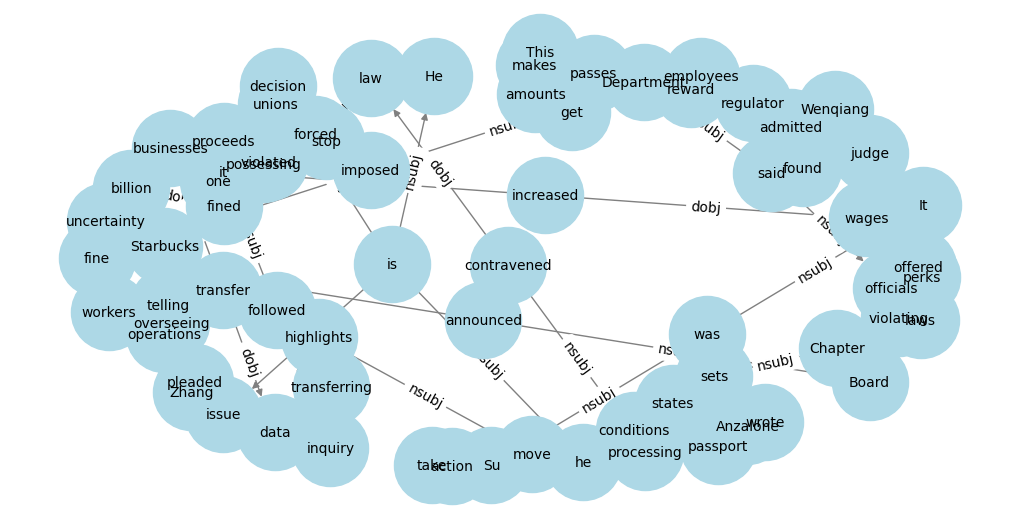

In [12]:
# Extract entity pairs and relationships
relations = []
for text in texts:
    doc = nlp(text)
    for token in doc:
        if token.dep_ in ("nsubj", "dobj"):  # Subject-object relationships
            head = token.head.text
            tail = token.text
            relation = token.dep_
            relations.append((head, relation, tail))

relations = relations[:50]
            
# Convert to DataFrame
relations_df = pd.DataFrame(relations, columns=["Entity1", "Relation", "Entity2"])
print(relations_df[:11])

# Create a relationship graph
G = nx.DiGraph()
for entity1, relation, entity2 in relations:
    G.add_edge(entity1, entity2, label=relation)

# Draw the graph
plt.figure(figsize=(10, 5))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=3000, font_size=10)
edge_labels = {(e1, e2): rel for e1, rel, e2 in relations}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.show()


terrible graph but entity and relationship extraction is more impt

         Entity1 Relation                           Entity2
0       violated    nsubj                         Starbucks
1       violated     dobj                 federal labor law
2      increased    nsubj                                it
3      increased     dobj                             wages
4        offered     dobj                         new perks
...          ...      ...                               ...
22394        saw     dobj                          S$39,632
22395  regulated    nsubj                               MAS
22396  regulated     dobj  cryptocurrency service providers
22397  possessed    nsubj                              they
22398  possessed     dobj                             money

[22399 rows x 3 columns]


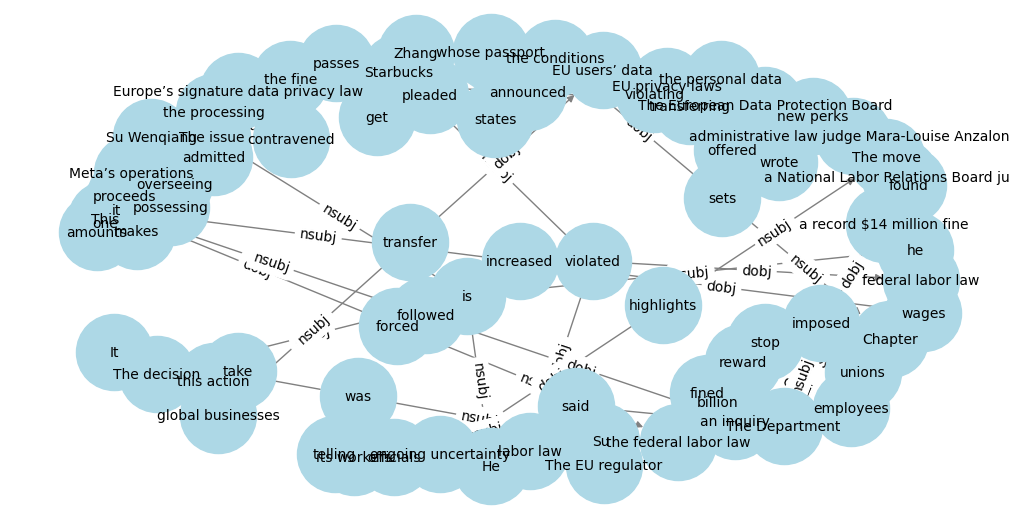

In [13]:
def get_noun_phrases(doc):
    noun_phrases = {chunk.root: chunk.text for chunk in doc.noun_chunks}  # Mapping root words to full phrases
    return noun_phrases

relations = []

# Process each text
for text in texts:
    doc = nlp(text)

    # Get noun phrases (e.g., "federal law" instead of just "law")
    noun_phrases = get_noun_phrases(doc)

    for token in doc:
        # Identify subject-object pairs (Who did what to whom?)
        if token.dep_ in ("nsubj", "dobj"):  # Subject-Object dependency
            head = token.head.text  # The main verb (action word)
            entity = noun_phrases.get(token, token.text)  # Use full noun phrase if available
            relation = token.dep_  # Relationship type (nsubj/dobj)
            relations.append((head, relation, entity))

# Convert extracted relationships to a DataFrame
relations_df = pd.DataFrame(relations, columns=["Entity1", "Relation", "Entity2"])

# Display results
print(relations_df)

# Create a directed graph
G = nx.DiGraph()

relations = relations[:50]

# Add edges for each relationship
for entity1, relation, entity2 in relations:
    G.add_edge(entity1, entity2, label=relation)

# Draw the graph
plt.figure(figsize=(10, 5))
pos = nx.spring_layout(G)  # Position nodes using a layout
nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=3000, font_size=10)

# Add labels to edges
edge_labels = {(e1, e2): rel for e1, rel, e2 in relations}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.show()

NEED MORE PREPROCESSING

         Entity1 Relation                           Entity2
0       violated    nsubj                         Starbucks
1       violated     dobj                 federal labor law
2      increased    nsubj                                it
3      increased     dobj                             wages
4        offered     dobj                         new perks
...          ...      ...                               ...
22394        saw     dobj                          S$39,632
22395  regulated    nsubj                               MAS
22396  regulated     dobj  cryptocurrency service providers
22397  possessed    nsubj                              they
22398  possessed     dobj                             money

[22399 rows x 3 columns]


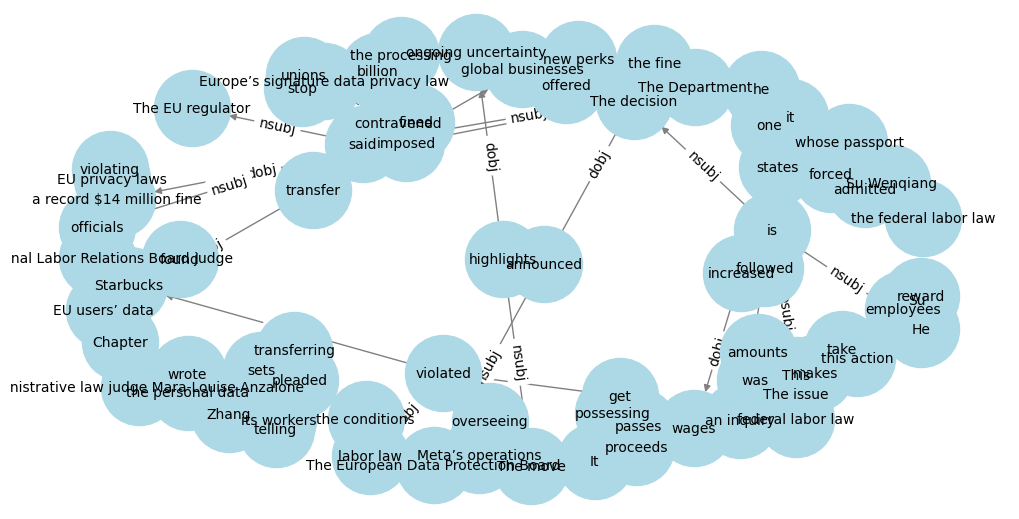

In [14]:
def get_noun_phrases(doc):
    noun_phrases = {chunk.root: chunk.text for chunk in doc.noun_chunks}  # Mapping root words to full phrases
    return noun_phrases

# Function to merge proper nouns joined by "and"
def merge_proper_nouns(doc):
    tokens = list(doc)
    merged_tokens = []
    i = 0

    while i < len(tokens):
        token = tokens[i]

        # If the token is a proper noun and followed by "and" + another proper noun
        if token.pos_ == "PROPN" and i + 2 < len(tokens) and tokens[i + 1].text.lower() == "and" and tokens[i + 2].pos_ == "PROPN":
            merged_entity = f"{token.text} and {tokens[i + 2].text}"
            merged_tokens.append(merged_entity)
            i += 3  # Skip the next two tokens ("and" and the second proper noun)
        else:
            merged_tokens.append(token.text)
            i += 1

    return merged_tokens

# List to store extracted relationships
relations = []

# Process each text
for text in texts:
    doc = nlp(text)

    # Get noun phrases (e.g., "federal law" instead of just "law")
    noun_phrases = get_noun_phrases(doc)

    # Merge proper nouns with "and"
    merged_tokens = merge_proper_nouns(doc)

    for token in doc:
        # Identify subject-object pairs (Who did what to whom?)
        if token.dep_ in ("nsubj", "dobj"):  # Subject-Object dependency
            head = token.head.text  # The main verb (action word)
            entity = noun_phrases.get(token, token.text)  # Use full noun phrase if available

            # Replace entity if it appears in the merged list
            if entity in merged_tokens:
                entity = merged_tokens[merged_tokens.index(entity)]

            relation = token.dep_  # Relationship type (nsubj/dobj)
            relations.append((head, relation, entity))

# Convert extracted relationships to a DataFrame
relations_df = pd.DataFrame(relations, columns=["Entity1", "Relation", "Entity2"])

# Display results
print(relations_df)

# Create a directed graph
G = nx.DiGraph()

relations = relations[:50]

# Add edges for each relationship
for entity1, relation, entity2 in relations:
    G.add_edge(entity1, entity2, label=relation)

# Draw the graph
plt.figure(figsize=(10, 5))
pos = nx.spring_layout(G)  # Position nodes using a layout
nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=3000, font_size=10)

# Add labels to edges
edge_labels = {(e1, e2): rel for e1, rel, e2 in relations}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.show()

In [15]:
relations_df[:20]

,Entity1,Relation,Entity2
0,violated,nsubj,Starbucks
1,violated,dobj,federal labor law
2,increased,nsubj,it
3,increased,dobj,wages
4,offered,dobj,new perks
5,found,nsubj,a National Labor Relations Board judge
6,is,nsubj,The decision
7,violated,nsubj,Starbucks
8,violated,dobj,labor law
9,stop,dobj,unions


In [19]:
# Load Hugging Face model for NER
model_name = "dbmdz/bert-large-cased-finetuned-conll03-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)

# Load NER pipeline
ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer)



# Extract named entities
for text in texts:
    ner_results = ner_pipeline(text)
    print(f"\nText: {text}")
    for entity in ner_results:
        print(f"{entity['word']} - {entity['entity']} (Score: {entity['score']:.2f})")

Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu



Text: Starbucks violated federal labor law when it increased wages and offered new perks and benefits only to non-union employees, a National Labor Relations Board judge found Thursday.

The decision is the latest in a series of NLRB rulings finding that Starbucks has violated labor law in its efforts to stop unions from forming in its coffee shops.

“The issue at the heart of this case is whether, under current Board law, [Starbucks] was entitled to explicitly reward employees,” for not participating in union activity, “while falsely telling its workers that the federal labor law forced it to take this action,” wrote administrative law judge Mara-Louise Anzalone. “It was not.”
Star - I-ORG (Score: 1.00)
##bu - I-ORG (Score: 1.00)
##cks - I-ORG (Score: 1.00)
National - I-ORG (Score: 1.00)
Labor - I-ORG (Score: 1.00)
Relations - I-ORG (Score: 1.00)
Board - I-ORG (Score: 1.00)
NL - I-ORG (Score: 0.99)
##RB - I-ORG (Score: 1.00)
Star - I-ORG (Score: 1.00)
##bu - I-ORG (Score: 1.00)
##cks


Text: On Thursday, the Brussels Criminal Court’s prosecutor, requested 20-year prison sentences for Alfredo H. and Indrit K. in the Black Eagle case, related to a large drug trafficking operation.

She identified these two Albanian nationals as the leaders of the criminal organisation responsible for the drug trafficking operation. Prosecution evidence includes cocaine seizures conducted throughout the investigation launched in 2020, with an estimated value of €13.42 million.

Alfredo H., pinpointed as one of the operation’s heads, was found to have connections with Italian mafia groups established in Limburg and heads of a larger organisation based in Majorca. "They implemented modern business methods, sharing resources, workforce, and equipment," explained the prosecutor.
Brussels - I-ORG (Score: 0.97)
Criminal - I-ORG (Score: 0.98)
Court - I-ORG (Score: 0.98)
Alfredo - I-PER (Score: 1.00)
H - I-PER (Score: 1.00)
. - I-PER (Score: 0.74)
In - I-PER (Score: 1.00)
##dr - I-PER (Score: 

KeyboardInterrupt: 

luke tacred dataset for relationships tbc